In [1]:
import pickle as pkl
import numpy as np
# PyTorch
import torch
from torch.utils.data import random_split
# PyG
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from sklearn.model_selection import KFold
# Optuna
import optuna
from optuna.samplers import RandomSampler
# NetworkX
import networkx as nx
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# Local
from models import GNN_model
from dataset import XASMolDataset
from utils.trainer import train_model, val_model, seed_everything

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')

Pytorch version: 2.4.1+cu124
PyG version: 2.5.3


In [3]:
# --- Path raw directory containing the data
path = "../"
dataset = XASMolDataset(path)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

In [4]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[12]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASMolDataset(492)
------------
Number of graphs: 492
Number of features: 12
Number of classes: 0

Data(x=[32, 12], edge_index=[2, 80], edge_attr=[80, 5], spectrum=[200], idx=[1], smiles='c12[c:2]3[c:3]([C:25](=[O:31])[H:40])[c:5]([H:41])[c:6]4[c:4]1[c:9]1[c:11]([c:10]([H:33])[c:7]4[C:8](=[O:28])[O:29][H:38])[c:12]([H:34])[c:14]([H:35])[c:15]4[c:13]1[c:17]1[c:19]([c:18]([H:43])[c:16]4[H:42])=[C:20]([O:26][H:39])[C:22]4([H:36])[C:23]([c:21]21)([C:24]1([H:37])[C:1]3([H:32])[O:27]1)[O:30]4')
------------
Number of nodes: 32
Number of edges: 80
Average node degree: 2.50
Has isolated nodes: False
Has self loops: False
Is undirected: True


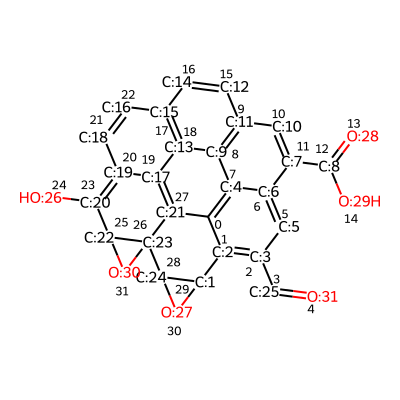

In [5]:
# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

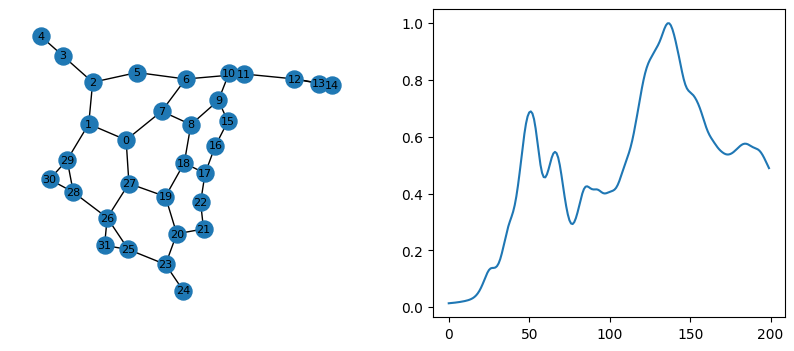

In [6]:
# --- Create subplot for plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show molecule spectrum
ax2.plot(data.spectrum)
plt.show()

In [ ]:
# Random seed to reproduce data split
generator = torch.Generator().manual_seed(5)
# Split dataset into train, validation and test sets
train_data, test_data = random_split(dataset, [0.833, 0.167], generator)

print(f'Length of training data: {len(train_data)}')
print(f'Length of testing data: {len(test_data)}')

torch.save(test_data, '../processed/test_coronene_pyg_new.pt')

Length of training data: 410
Length of testing data: 82


#### Tuning

In [27]:
def objective(trial):
    # Hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 3, 5)
    hidden_channel = trial.suggest_categorical('hidden_channels', [32, 64, 128, 256])
    gnn_type = trial.suggest_categorical('gnn_type', ['gat'])
    drop_ratio  = trial.suggest_float('drop_ratio', 0.1, 0.7, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)

    # Set model prameters
    num_tasks = 200
    # Set hidden layers based on chasen value
    in_channels = [hidden_channel] * (num_layers - 1)
    in_channels.insert(0, dataset.num_features)
    out_channels = [hidden_channel] * num_layers
    heads = 1
    graph_pooling = 'mean'
    
    # Set up k-fold cross validation
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    # List to store fold validation loss
    kfold_loss = []
    # Run training on each k-fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
        # Set up the data loaders
        train_loader = DataLoader(dataset=train_data, batch_size=328,
                                  sampler=torch.utils.data.SubsetRandomSampler(train_idx))
        val_loader = DataLoader(dataset=train_data, batch_size=82,
                                sampler=torch.utils.data.SubsetRandomSampler(val_idx))
        # Seed for reproducibility
        seed_everything(199)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Create model
        model = GNN_model(num_tasks, num_layers, in_channels, out_channels, gnn_type, 
                          heads, drop_ratio, graph_pooling, learning_rate).to(device)
        # Set up model tools
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
    
        num_epochs = 400
        # Run model training
        for epoch in range(num_epochs):
            loss = train_model(model, train_loader, optimizer, device)
            val_error = val_model(model, val_loader, device)

        # Add final val_error of fold to list
        kfold_loss.append(val_error)
    
    # Get the average k-fold loss
    average_loss = np.average(val_error)

    return average_loss


In [29]:
study_name = 'gat_study'
storage_name = 'sqlite:///tune_studies/{}.db'.format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, sampler=RandomSampler(), load_if_exists=True)
study.optimize(objective, n_trials=50)

[I 2025-02-17 20:22:31,485] Using an existing study with name 'gat_study' instead of creating a new one.


[I 2025-02-17 20:23:17,019] Trial 50 finished with value: 0.01666570082306862 and parameters: {'num_layers': 4, 'hidden_channels': 32, 'gnn_type': 'gat', 'drop_ratio': 0.30000000000000004, 'learning_rate': 0.008727400492088724}. Best is trial 50 with value: 0.01666570082306862.
[I 2025-02-17 20:24:06,275] Trial 51 finished with value: 0.05957680195569992 and parameters: {'num_layers': 4, 'hidden_channels': 32, 'gnn_type': 'gat', 'drop_ratio': 0.55, 'learning_rate': 0.00015760835485532291}. Best is trial 50 with value: 0.01666570082306862.
[I 2025-02-17 20:24:46,761] Trial 52 finished with value: 0.018270647153258324 and parameters: {'num_layers': 3, 'hidden_channels': 32, 'gnn_type': 'gat', 'drop_ratio': 0.15000000000000002, 'learning_rate': 0.006260391254992442}. Best is trial 50 with value: 0.01666570082306862.
[I 2025-02-17 20:25:32,384] Trial 53 finished with value: 0.018510453402996063 and parameters: {'num_layers': 5, 'hidden_channels': 128, 'gnn_type': 'gat', 'drop_ratio': 0.450

In [30]:
best = study.best_trial
print(f'Best model: {best.number}')
print(f'Best validation loss: {best.value:.6f}')
print(f'-----')
gnn_params = {}
for key, value in best.params.items():
    print(f'{key}: {value}')
    gnn_params[key] = value

Best model: 50
Best validation loss: 0.016666
-----
num_layers: 4
hidden_channels: 32
gnn_type: gat
drop_ratio: 0.30000000000000004
learning_rate: 0.008727400492088724


### Run training on best model

In [31]:
final_loader = DataLoader(train_data, batch_size=410, shuffle=True)

In [32]:
num_tasks = 200
num_layers = gnn_params['num_layers']
hidden_channels = gnn_params['hidden_channels']
in_channels = [hidden_channels] * (num_layers - 1)
in_channels.insert(0, dataset.num_features)
out_channels = [hidden_channels] * num_layers
gnn_type = gnn_params['gnn_type']
heads = 1
drop_ratio = gnn_params['drop_ratio']
graph_pooling = 'mean'

seed_everything(199)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = GNN_model(num_tasks, num_layers, in_channels, out_channels,
                   gnn_type, heads, drop_ratio, graph_pooling).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=gnn_params['learning_rate'], betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

num_epochs = 400
train_losses = []
val_losses = []
results = []

for epoch in range(num_epochs):
    loss = train_model(model, final_loader, optimizer, device)
    
    train_losses.append(loss)

    results.append((epoch, loss))

name = gnn_params['gnn_type'] + '_model.pth'

torch.save(model.state_dict(), './models/' + name)

with open('./models/' + gnn_params['gnn_type'] + '_results.pkl', 'wb') as f:
        pkl.dump(results, f)

In [33]:
results

[(0, 0.25756561756134033),
 (1, 0.2463987171649933),
 (2, 0.23444649577140808),
 (3, 0.22695878148078918),
 (4, 0.21787166595458984),
 (5, 0.20964716374874115),
 (6, 0.20146390795707703),
 (7, 0.19365911185741425),
 (8, 0.18655811250209808),
 (9, 0.17534670233726501),
 (10, 0.16770367324352264),
 (11, 0.15663304924964905),
 (12, 0.1458066999912262),
 (13, 0.13668915629386902),
 (14, 0.12125930935144424),
 (15, 0.1075969859957695),
 (16, 0.09433446824550629),
 (17, 0.08086617290973663),
 (18, 0.06545116752386093),
 (19, 0.05470997095108032),
 (20, 0.04717720299959183),
 (21, 0.0421869270503521),
 (22, 0.041034452617168427),
 (23, 0.03930627554655075),
 (24, 0.03839555010199547),
 (25, 0.03470424935221672),
 (26, 0.033836543560028076),
 (27, 0.03132806345820427),
 (28, 0.028304895386099815),
 (29, 0.026859620586037636),
 (30, 0.02609812654554844),
 (31, 0.026157760992646217),
 (32, 0.02695871889591217),
 (33, 0.02561790682375431),
 (34, 0.02542307786643505),
 (35, 0.02516758441925049),
 